In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *
from pyfunctions import *

In [4]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

### Load observational datasets

In [6]:
# CLM-SP LAI on sparse grid
la = get_la()
SP_sg = get_SP('h0')

GM_sp = gmean(amax(SP_sg).mean(dim='year'),la).compute()
BM_sp = bmean(amax(SP_sg).mean(dim='year'),la).compute()

In [8]:
# load regridded ILAMB datasets (MODIS, AVHRR, AVH15C1)
ds_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_LAI_regridded.nc')
Amax_LAI_MODIS = amax(ds_ilamb.MODIS_LAI).mean(dim='year')

jvals, ivals = get_sparsegrid()

GM_MODIS = gmean(amax(ds_ilamb.MODIS_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
mask = xr.where(GM_MODIS!=0,1,0)
GM_AVHRR = gmean(amax(ds_ilamb.AVHRR_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
GM_AVH15C1 = gmean(amax(ds_ilamb.AVH15C1_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()

GM_LAI_obs = [GM_MODIS, GM_AVHRR, GM_AVH15C1, GM_sp]

In [38]:
#Load ILAMB GPP datasets
ds_gpp_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_GPP_regridded_v3.nc')

In [39]:
la=xr.open_dataset('../sparsegrid_landarea.nc').landarea
ilamb_cf=1e-9*la.sum()*365

In [40]:
FLX_gpp = ilamb_cf*gmean(amean(ds_gpp_ilamb.FLUXCOM_GPP[:,jvals,ivals]).mean(dim='year'),la).compute()
wecann_gpp = ilamb_cf*gmean(amean(ds_gpp_ilamb.WECANN_GPP[:,jvals,ivals]).mean(dim='year'),la).compute()

### Readin PPE ensemble

In [14]:
ds_h0=get_exp('transient',dvs=['TLAI','GPP'],yy=(2000,2014))

In [15]:
la=xr.open_dataset('../sparsegrid_landarea.nc').landarea
cf=1e-9*la.sum()*24*60*60*365

In [16]:
t=slice(str(2000),str(2005))
GM_Amax_lai_lhc = gmean(amax(ds_h0['TLAI'].sel(time=t)).mean(dim='year'),la).compute()

In [17]:
t=slice(str(2007),str(2013))
GM_gpp_lhc = cf*gmean(amean(ds_h0['GPP'].sel(time=t)).mean(dim='year'),la).compute()

In [18]:
obs_lai_min = np.min(GM_LAI_obs)
obs_lai_max = np.max(GM_LAI_obs)

(0.0, 226.0)

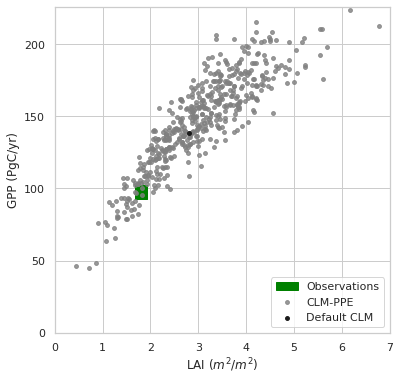

In [41]:
import seaborn as sns

plt.figure(figsize=[6,6])
plt.rcParams.update({'font.size': 26})

sns.set(style="whitegrid")
ax = plt.subplot(1,1,1)

# obs box
x = np.linspace(obs_lai_min,obs_lai_max,5)
y1 = np.tile(FLX_gpp,5)
y2 = np.tile(wecann_gpp,5)
ax.fill_between(x,y1,y2,color='green',label='Observations')

ax.scatter(GM_Amax_lai_lhc,GM_gpp_lhc,s=15,color='grey',alpha=0.8,label='CLM-PPE')
ax.scatter(GM_Amax_lai_lhc[0],GM_gpp_lhc[0],s=15,color='k',label='Default CLM')

plt.legend(loc='lower right')
plt.xlabel('LAI ${(m^2}$/${m^2}$)')
plt.ylabel('GPP (PgC/yr)')
plt.xlim([0,7])
plt.ylim([0,226])

#plt.savefig('./figs/BGC_cesm23/global_LAIvGPP_wOBS.png',dpi=300,transparent=True)